# Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

import joblib

# Load data and define functions

In [2]:
def load_tif_files(directory):
    """Load and return a list of arrays representing TIFF files from a directory."""
    tif_files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.tif')]
    bands_list = [rasterio.open(fp).read() for fp in tif_files]
    return bands_list

def count_non_nan_pixels(band1, band2):
    """Count the number of non-NaN pixels based on two bands."""
    return np.sum(~np.isnan(band1) & ~np.isnan(band2))

def downsample_data(bands_list, target_class_size):
    """Downsample the data to the target_class_size, ensuring no NaN values."""
    sampled_pixels = []
    for bands in bands_list:
        band1, band2 = bands[0], bands[1]
        non_nan_indices = np.argwhere(~np.isnan(band1) & ~np.isnan(band2))
        np.random.shuffle(non_nan_indices)
        selected_indices = non_nan_indices[:min(len(non_nan_indices), target_class_size)]
        sampled_pixels.append(selected_indices)
        if len(sampled_pixels) >= target_class_size:
            break
    return np.vstack(sampled_pixels)  # Ensure the result is a 2D array of indices

def extract_tile_features(band, i, j, window_size=1):
    """Extract features from a 3x3 tile around the pixel at (i, j) in the band, ensuring no NaNs in the tile."""
    tile = band[max(0, i-window_size):i+window_size+1, max(0, j-window_size):j+window_size+1]
    if np.isnan(tile).any():
        return None  # Skip tiles with NaN values
    mean_val = np.nanmean(tile)
    std_val = np.nanstd(tile)
    min_val = np.nanmin(tile)
    max_val = np.nanmax(tile)
    return mean_val, std_val, min_val, max_val

# def extract_features(bands, indices):
#     """Extract features from the downsampled pixels, including ratios to band 3 mean, excluding NaN-containing tiles."""
#     features = []
#     band1, band2, band3 = bands[0], bands[1], bands[2]
#     for i, j in indices:
#         band1_features = extract_tile_features(band1, i, j)
#         band2_features = extract_tile_features(band2, i, j)
#         if band1_features and band2_features:  # Only add features if neither are None
#             band3_mean = np.nanmean(band3[max(0, i-1):i+2, max(0, j-1):j+2])
#             if not np.isnan(band3_mean):
#                 band1_ratio = band1[i, j] / band3_mean
#                 band2_ratio = band2[i, j] / band3_mean
#                 features.append(band1_features + band2_features + (band1_ratio, band2_ratio))
#     return np.array(features)

# Optional simpler feature extraction without band 3 ratios
def extract_features(bands, indices):
    """Extract features from the downsampled pixels, excluding band 3 ratios."""
    features = []
    band1, band2 = bands[0], bands[1]
    for i, j in indices:
        band1_features = extract_tile_features(band1, i, j)
        band2_features = extract_tile_features(band2, i, j)
        if band1_features is not None and band2_features is not None:
            features.append(band1_features + band2_features)
    return np.array(features)

def preprocess_data(non_forest_data, forest_data, target_class_size):
    """Preprocess data to extract features and labels after downsampling."""
    non_forest_downsampled = [downsample_data([bands], target_class_size=target_class_size//len(non_forest_data)) for bands in non_forest_data]
    forest_downsampled = [downsample_data([bands], target_class_size=target_class_size//len(forest_data)) for bands in forest_data]
    
    non_forest_features = np.vstack([extract_features(bands, indices) for bands, indices in zip(non_forest_data, non_forest_downsampled)])
    forest_features = np.vstack([extract_features(bands, indices) for bands, indices in zip(forest_data, forest_downsampled)])
    
    X = np.vstack([non_forest_features, forest_features])
    y = np.hstack([np.zeros(non_forest_features.shape[0]), np.ones(forest_features.shape[0])])
    
    return X, y

In [3]:
target_class_size = 20000  

non_forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\non_forest"
forest_dir = r"D:\Development\RESEARCH\MarvinBlue\Data\forest"

non_forest_data = load_tif_files(non_forest_dir)
forest_data = load_tif_files(forest_dir)
print(f"Loaded {len(non_forest_data)} non-forest files and {len(forest_data)} forest files.")

# Count and Print Non-NaN Pixels
non_forest_pixel_count = sum(count_non_nan_pixels(bands[0], bands[1]) for bands in non_forest_data)
forest_pixel_count = sum(count_non_nan_pixels(bands[0], bands[1]) for bands in forest_data)
total_pixels = non_forest_pixel_count + forest_pixel_count

print(f"Non-Forest Non-NaN Pixels: {non_forest_pixel_count} ({(non_forest_pixel_count / total_pixels) * 100:.2f}%)")
print(f"Forest Non-NaN Pixels: {forest_pixel_count} ({(forest_pixel_count / total_pixels) * 100:.2f}%)")

# Feature Extraction and Downsampling
X, y = preprocess_data(non_forest_data, forest_data, target_class_size=target_class_size)

# Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Validation set size: {X_val.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Normalize Data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_val_norm = scaler.transform(X_val)
X_test_norm = scaler.transform(X_test)

Loaded 31 non-forest files and 45 forest files.
Non-Forest Non-NaN Pixels: 979214 (4.68%)
Forest Non-NaN Pixels: 19928127 (95.32%)
Training set size: 27379 samples
Validation set size: 5867 samples
Test set size: 5867 samples


# Random Forest 

Best Parameters: {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 5, 'min_samples_leaf': 2}
Best Validation F1 Score: 0.7769938621300855


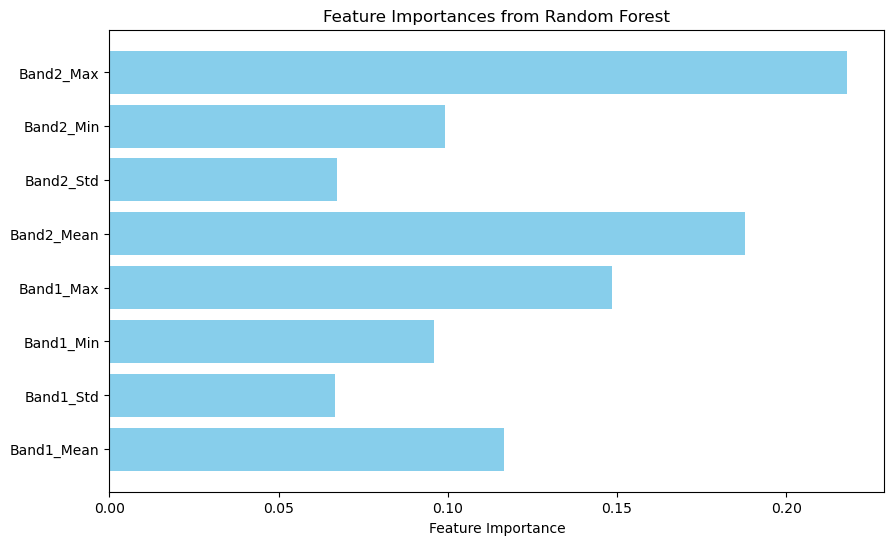

Feature Importances:
Band1_Mean: 0.1166
Band1_Std: 0.0666
Band1_Min: 0.0958
Band1_Max: 0.1485
Band2_Mean: 0.1879
Band2_Std: 0.0673
Band2_Min: 0.0991
Band2_Max: 0.2180


In [4]:
def rf_grid_search(X_train, y_train, X_val, y_val, param_grid):
    """
    Perform a grid search for RandomForestClassifier without cross-validation using F1 score.

    Parameters:
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_val: Validation feature set.
    - y_val: Validation labels.
    - param_grid: Dictionary of hyperparameters to search over.

    Returns:
    - best_params: Dictionary of the best hyperparameters.
    - best_score: Best F1 validation score.
    - best_model: The best trained Random Forest model.
    - feature_importances: Array of feature importances from the best model.
    """

    best_score = 0
    best_params = {}
    best_model = None
    feature_importances = None

    for n_estimators in param_grid.get('n_estimators', [100]):
        for max_depth in param_grid.get('max_depth', [None]):
            for min_samples_split in param_grid.get('min_samples_split', [2]):
                for min_samples_leaf in param_grid.get('min_samples_leaf', [1]):
                    # Define the model with the current parameters
                    rf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        min_samples_split=min_samples_split,
                        min_samples_leaf=min_samples_leaf,
                        random_state=42
                    )
                    
                    # Train the model
                    rf.fit(X_train, y_train)
                    
                    # Validate the model
                    y_pred = rf.predict(X_val)
                    score = f1_score(y_val, y_pred, average='weighted')  # Calculate weighted F1 score
                    
                    # Check if this is the best score we've seen so far
                    if score > best_score:
                        best_score = score
                        best_params = {
                            'n_estimators': n_estimators,
                            'max_depth': max_depth,
                            'min_samples_split': min_samples_split,
                            'min_samples_leaf': min_samples_leaf
                        }
                        best_model = rf
                        feature_importances = rf.feature_importances_

    return best_params, best_score, best_model, feature_importances

# Example usage
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_best_params, rf_best_score, rf_best_model, rf_feature_importances = rf_grid_search(X_train_norm, y_train, X_val_norm, y_val, param_grid)

print(f"Best Parameters: {rf_best_params}")
print(f"Best Validation F1 Score: {rf_best_score}")

# Plotting the best feature importances
feature_names = [
    'Band1_Mean', 'Band1_Std', 'Band1_Min', 'Band1_Max', 
    'Band2_Mean', 'Band2_Std', 'Band2_Min', 'Band2_Max']

if rf_feature_importances is not None:
    plt.figure(figsize=(10, 6))
    plt.barh(feature_names, rf_feature_importances, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.title('Feature Importances from Random Forest')
    plt.show()

    print("Feature Importances:")
    for name, importance in zip(feature_names, rf_feature_importances):
        print(f"{name}: {importance:.4f}")


rf_classifier = rf_best_model

#  SVM

Best SVM Validation F1 Score: 0.7793 with parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
SVM Classification Report (Validation Set):
              precision    recall  f1-score   support

  Non-Forest       0.83      0.70      0.76      2901
      Forest       0.75      0.86      0.80      2966

    accuracy                           0.78      5867
   macro avg       0.79      0.78      0.78      5867
weighted avg       0.79      0.78      0.78      5867



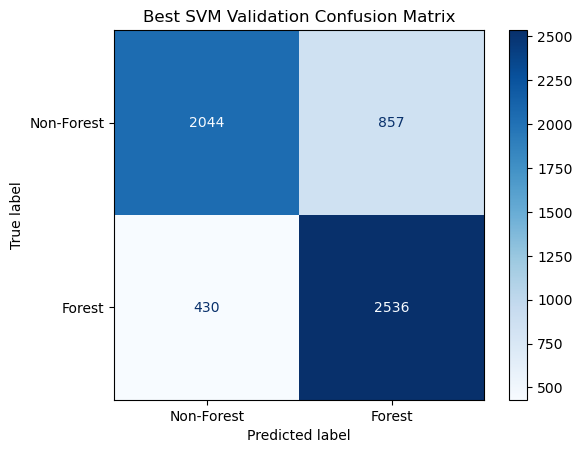

Best Parameters: {'C': 0.1, 'kernel': 'linear', 'gamma': 'scale'}
Best Validation F1 Score: 0.7792891587870932


In [5]:
def svm_grid_search(X_train, y_train, X_val, y_val, param_grid):
    """
    Perform a grid search for SVC without cross-validation using F1 score.

    Parameters:
    - X_train: Training feature set.
    - y_train: Training labels.
    - X_val: Validation feature set.
    - y_val: Validation labels.
    - param_grid: Dictionary of hyperparameters to search over.

    Returns:
    - best_params: Dictionary of the best hyperparameters.
    - best_score: Best F1 validation score.
    - best_model: The best trained SVM model.
    """

    best_score = 0
    best_params = {}
    best_model = None

    for C in param_grid.get('C', [1]):
        for kernel in param_grid.get('kernel', ['rbf']):
            for gamma in param_grid.get('gamma', ['scale']):
                # Define the model with the current parameters
                svm_classifier = SVC(C=C, kernel=kernel, gamma=gamma, probability=True)
                svm_classifier.fit(X_train, y_train)
                
                # Validate the model
                svm_val_predictions = svm_classifier.predict(X_val)
                svm_val_f1 = f1_score(y_val, svm_val_predictions, average='weighted')  # Calculate weighted F1 score
                
                # Check if this is the best score we've seen so far
                if svm_val_f1 > best_score:
                    best_score = svm_val_f1
                    best_params = {
                        'C': C,
                        'kernel': kernel,
                        'gamma': gamma
                    }
                    best_model = svm_classifier

    # Evaluate the best model on the validation set
    print(f"Best SVM Validation F1 Score: {best_score:.4f} with parameters: {best_params}")
    print("SVM Classification Report (Validation Set):")
    best_val_predictions = best_model.predict(X_val)
    print(classification_report(y_val, best_val_predictions, target_names=['Non-Forest', 'Forest']))
    
    ConfusionMatrixDisplay.from_predictions(y_val, best_val_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues)
    plt.title("Best SVM Validation Confusion Matrix")
    plt.show()

    return best_model, best_params, best_score

# Example usage
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_best_model, svm_best_params, svm_best_score = svm_grid_search(X_train_norm, y_train, X_val_norm, y_val, param_grid)

print(f"Best Parameters: {svm_best_params}")
print(f"Best Validation F1 Score: {svm_best_score}")


svm_classifier = svm_best_model

# Models Comparison

,Model,Accuracy,Precision (Non-Forest),Recall (Non-Forest),F1-Score (Non-Forest),Precision (Forest),Recall (Forest),F1-Score (Forest)
0,Random Forest,0.774161,0.809029,0.705084,0.753488,0.748216,0.840401,0.791634
1,SVM,0.779615,0.811932,0.715529,0.760689,0.755096,0.841068,0.795767


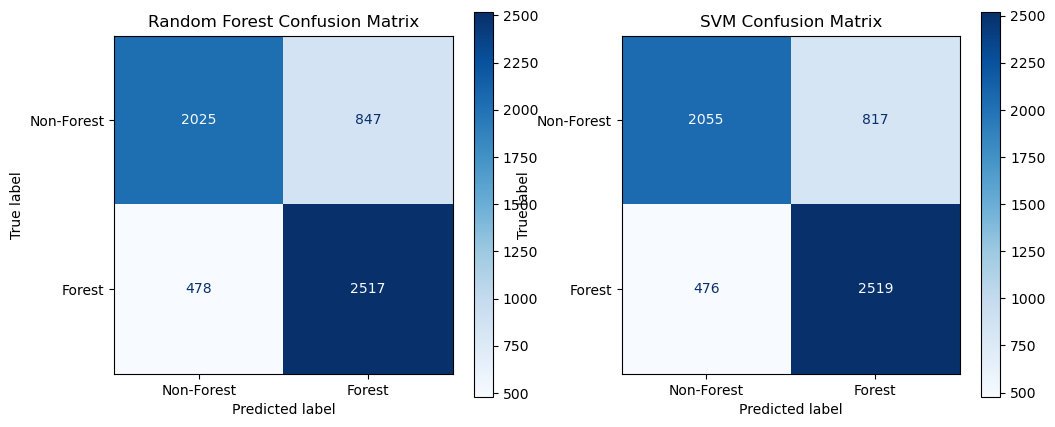

In [6]:
def compare_models(rf_classifier, svm_classifier, X_test, y_test):
    rf_test_predictions = rf_classifier.predict(X_test)
    svm_test_predictions = svm_classifier.predict(X_test)
    
    rf_test_accuracy = (rf_test_predictions == y_test).mean()
    svm_test_accuracy = (svm_test_predictions == y_test).mean()
    
    rf_classification_report = classification_report(y_test, rf_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    svm_classification_report = classification_report(y_test, svm_test_predictions, target_names=['Non-Forest', 'Forest'], output_dict=True)
    
    metrics_df = pd.DataFrame({
        'Model': ['Random Forest', 'SVM'],
        'Accuracy': [rf_test_accuracy, svm_test_accuracy],
        'Precision (Non-Forest)': [rf_classification_report['Non-Forest']['precision'], svm_classification_report['Non-Forest']['precision']],
        'Recall (Non-Forest)': [rf_classification_report['Non-Forest']['recall'], svm_classification_report['Non-Forest']['recall']],
        'F1-Score (Non-Forest)': [rf_classification_report['Non-Forest']['f1-score'], svm_classification_report['Non-Forest']['f1-score']],
        'Precision (Forest)': [rf_classification_report['Forest']['precision'], svm_classification_report['Forest']['precision']],
        'Recall (Forest)': [rf_classification_report['Forest']['recall'], svm_classification_report['Forest']['recall']],
        'F1-Score (Forest)': [rf_classification_report['Forest']['f1-score'], svm_classification_report['Forest']['f1-score']]
    })
    
    display(metrics_df)
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    ConfusionMatrixDisplay.from_predictions(y_test, rf_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[0])
    axes[0].set_title("Random Forest Confusion Matrix")
    
    ConfusionMatrixDisplay.from_predictions(y_test, svm_test_predictions, display_labels=['Non-Forest', 'Forest'], cmap=plt.cm.Blues, ax=axes[1])
    axes[1].set_title("SVM Confusion Matrix")
    
    plt.show()

# Compare Models
compare_models(rf_classifier, svm_classifier, X_test_norm, y_test)

# Save the Models

In [7]:

joblib.dump(rf_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\rf_model_tile.pkl')
joblib.dump(svm_classifier, r'D:\Development\RESEARCH\MarvinBlue\Results\svm_model_tile.pkl')
joblib.dump(scaler, r'D:\Development\RESEARCH\MarvinBlue\Results\scaler_tile.pkl')
print("Models and scaler saved successfully.")

Models and scaler saved successfully.
